# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [253]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [254]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 20:28:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [        <=>         ] 201.24M  12.4MB/s    in 8.5s    

2024-10-20 20:28:54 (23.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [255]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [256]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [257]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [258]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [259]:
set_random_seed(42)

In [260]:
set_random_seed(42)
model =  linear_model.Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
rmse_for_model = mean_squared_error(y_test, y_pred, squared = False)
print(rmse_for_model)

9.510160820470436


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [261]:
constant = np.full(shape = len(y_test), fill_value = np.mean(y_test))
best_rmse_metric = mean_squared_error(y_test, constant, squared = False)
print(best_rmse_metric)

10.851909820717683


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [262]:
set_random_seed(42)

In [263]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
class My_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
      assert len(x) == len(y)
      self.x = x
      self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
      idx = idx % len(self.x)
      return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [265]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
train_set = My_dataset(X_train_scaled, y_train)
test_set = My_dataset(X_test_scaled, y_test)

train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True,)

test_dataloader = torch.utils.data.DataLoader(
  test_set, batch_size=64, shuffle=False, )


class My_model(torch.nn.Module):
  def __init__(self):
        super(My_model, self).__init__()
        self.linear1 = torch.nn.Linear(90 ,1)

  def forward(self, x):
        x = self.linear1(x)
        return x
set_random_seed(42)
model = My_model()


def optimizer(parameters, lr = 0.01):
  for parameter in parameters:
    if parameter.grad is not None:
      parameter.data = parameter.data - lr * parameter.grad




In [266]:
def mse(y_true, y_pred):
  difference = y_true.view(-1, 1) - y_pred
  return torch.mean(torch.square(difference))
train_loss = []
test_loss = []

In [267]:
for epouch in range(10):
  train_loss_accumulate = 0
  test_loss_accumulate = 0
  for batch in tqdm(train_dataloader):
        x_train = batch["sample"]
        y_train = batch["target"].view(-1, 1)
        y_pred = model(x_train)
        loss = mse(y_train, y_pred)
        loss.backward()
        optimizer(model.parameters())
        model.zero_grad()
        train_loss_accumulate += loss.item()
  av_train_loss = np.sqrt(train_loss_accumulate / len(train_dataloader))
  train_loss.append(av_train_loss)



  with torch.no_grad():
    for batch in tqdm(test_dataloader):
      x_test = batch["sample"]
      y_test = batch["target"].view(-1, 1)
      y_pred = model(x_test)
      loss = mse(y_test, y_pred)
      test_loss_accumulate += loss.item()
    av_test_loss = np.sqrt(test_loss_accumulate / len(test_dataloader))
    test_loss.append(av_test_loss)



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

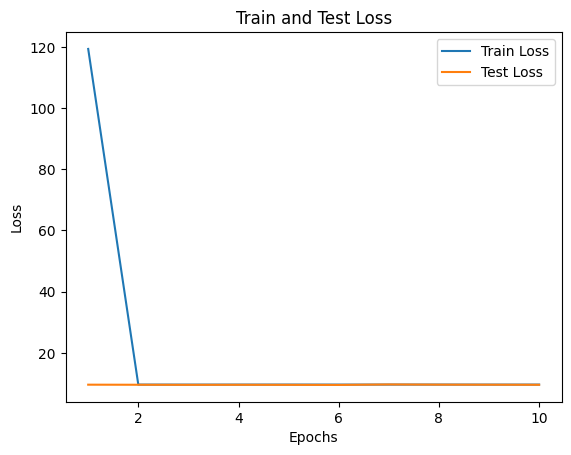

In [268]:
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
set_random_seed(42)

In [ ]:
# Заново подготовим данные
df = pd.read_csv('data.txt.zip', header=None)
df.head()
df.shape

(515345, 91)

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
# Масштабируем данные
scaler_x = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

In [126]:
set_random_seed(42)
train_set = My_dataset(X_train_scaled, y_train_scaled)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 16, shuffle = True )
test_set = My_dataset(X_test_scaled, y_test_scaled)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 16, shuffle = False)

model = nn.Sequential()
model.add_module("l1", nn.Linear(90, 75))
model.add_module("l2", nn.ReLU())
model.add_module("l3", nn.Linear(75, 60))
model.add_module("l4", nn.ReLU())
model.add_module("d5", nn.Dropout(p = 0.2))
model.add_module('l6', nn.Linear(60, 45))
model.add_module("l7", nn.ReLU())
model.add_module('d8', nn.Dropout(p=0.2))
model.add_module('l9', nn.Linear(45, 15))
model.add_module("l10", nn.ReLU())
model.add_module("l11", nn.Linear(15, 1))

In [127]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay= 0.01, momentum=0.9)
epoch_number = 5

In [128]:

def train(model, optimizer, train_loader):
  model.train()
  train_loss_to_accumulate = 0

  for batch in tqdm(train_loader):
      x_train = batch['sample'].float()
      y_train = batch["target"].view(-1, 1).float()
      y_pred = model(x_train)
      loss = F.mse_loss(y_pred, y_train)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      y_pred_denorm = scaler_y.inverse_transform(y_pred.view(-1, 1).detach().numpy())
      y_train_denorm = scaler_y.inverse_transform(y_train.view(-1, 1).detach().numpy())
      mse_denorm = np.mean((y_pred_denorm - y_train_denorm) ** 2)
      train_loss_to_accumulate += mse_denorm

  train_loss = np.sqrt(train_loss_to_accumulate / len(train_loader))
  return train_loss


def test(model, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    test_loss_to_accumulate = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_test = batch['sample'].float()
            y_test = batch['target'].view(-1, 1).float()

            y_pred = model(x_test)


            y_pred_denorm = scaler_y.inverse_transform(y_pred.view(-1, 1).detach().numpy())
            y_test_denorm = scaler_y.inverse_transform(y_test.view(-1, 1).detach().numpy())
            mse_denorm = np.mean((y_pred_denorm - y_test_denorm) ** 2)
            test_loss_to_accumulate += mse_denorm

    test_loss = np.sqrt(test_loss_to_accumulate / len(test_loader))
    return test_loss


In [129]:
set_random_seed(42)

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

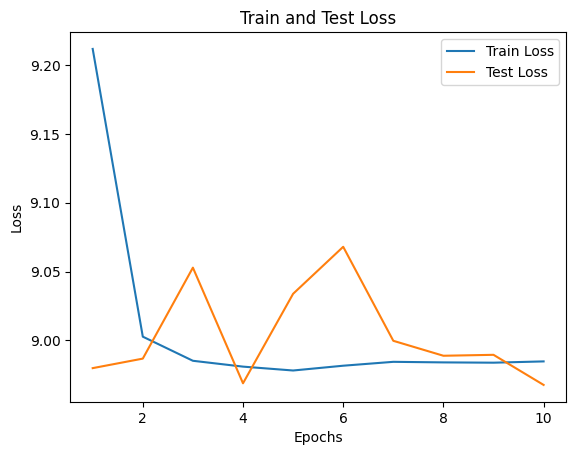

[8.979871269303873, 8.986792898473244, 9.052878565358002, 8.96886440959628, 9.033878427024264, 9.068032532282157, 8.999731828062497, 8.98887027074188, 8.98954570623315, 8.967677535723068]
[9.211784915091293, 9.002737218718977, 8.98521431424502, 8.980970552541498, 8.9781543162383, 8.981633932261504, 8.984455057251589, 8.984044665749314, 8.983832248516437, 8.984761674503025]


In [130]:
# ೭੧(❛〜❛✿)੭೨ Go forward!
train_list = []
test_list = []
for epoch in range(10):
  train_error = train(model, optimizer, train_loader)
  test_error = test(model, test_loader)
  train_list.append(train_error)
  test_list.append(test_error)

plt.plot(range(1, 11), train_list, label='Train Loss')
plt.plot(range(1, 11), test_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

print(test_list)
print(train_list)

Попробуем использовать BatchNormalization и добавить еще слой линейной регрессиии


In [ ]:
# Заново подготовим данные
df = pd.read_csv('data.txt.zip', header=None)
df.head()
df.shape

(515345, 91)

In [25]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [26]:
# Масштабируем данные
scaler_x = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

In [28]:
set_random_seed(42)

In [150]:
set_random_seed(42)
train_set = My_dataset(X_train_scaled, y_train_scaled)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 16, shuffle = True )
test_set = My_dataset(X_test_scaled, y_test_scaled)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 16, shuffle = False)

model2 = nn.Sequential()
model2.add_module("l1", nn.Linear(90, 75))
model2.add_module("bn1", nn.BatchNorm1d(75))
model2.add_module("l2", nn.ReLU())
model2.add_module("l3", nn.Linear(75, 60))
model2.add_module("l4", nn.ReLU())
model2.add_module("l5", nn.Dropout(p=0.2))
model2.add_module("l6", nn.Linear(60, 45))
model2.add_module("l7", nn.ReLU())
model2.add_module("l8", nn.Dropout(p=0.2))
model2.add_module("l9", nn.Linear(45, 30))
model2.add_module("bn4", nn.BatchNorm1d(30))
model2.add_module("l10", nn.ReLU())
model2.add_module("l11", nn.Linear(30, 15))
model2.add_module("bn5", nn.BatchNorm1d(15))
model2.add_module("l12", nn.ReLU())
model2.add_module("l13", nn.Linear(15, 1))


In [134]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay = 1e-5)

In [135]:
set_random_seed(42)

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

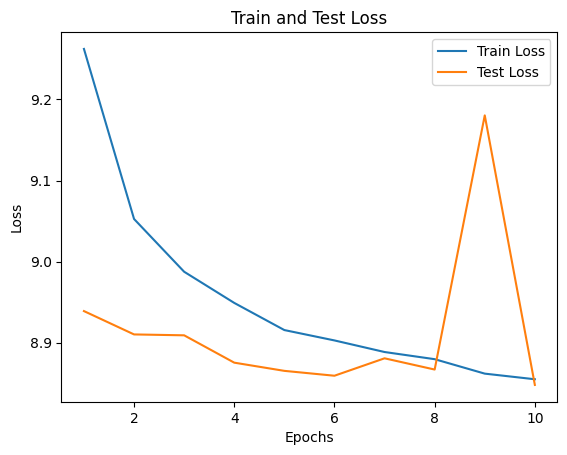

[8.93899978655408, 8.910216745329473, 8.909117928550168, 8.87540487443589, 8.865291298450352, 8.859282993379649, 8.880765650758342, 8.866911664469843, 9.180342137765091, 8.84795320451506]
[9.262278221408605, 9.052578014572381, 8.987509430677973, 8.949074361671727, 8.915601866415242, 8.90281420220606, 8.888534861520869, 8.879696479717014, 8.861876520352318, 8.854937205802015]


In [136]:
set_random_seed(42)
train_list = []
test_list = []
counter = 1
for epoch in range(10):
  train_error = train(model2, optimizer2, train_loader)
  test_error = test(model2, test_loader)
  train_list.append(train_error)
  test_list.append(test_error)
  counter +=1
  if test_error <= 8.79:
    break


plt.plot(range(1, counter), train_list, label='Train Loss')
plt.plot(range(1, counter), test_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

print(test_list)
print(train_list)

In [137]:
print(min(test_list))

8.84795320451506


Попробуем изменить размер батча

In [152]:
train_loader2 = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True )
test_loader2 = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = False)


In [153]:
optimizer3 = torch.optim.AdamW(model2.parameters())

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

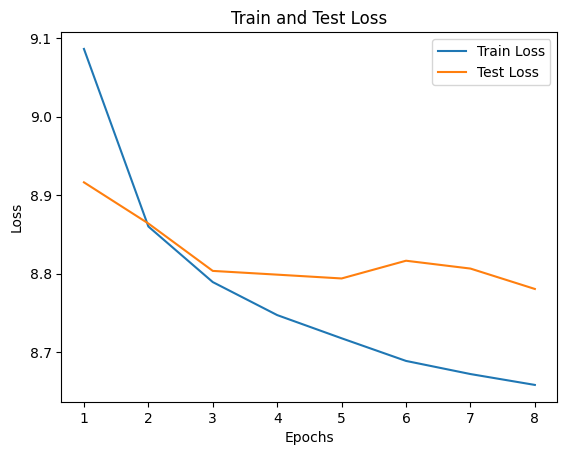

[8.91627561370637, 8.863914351132623, 8.803596360746202, 8.798835410800303, 8.793984668752758, 8.816545457589156, 8.80656125478355, 8.780630361366233]
[9.085980280881687, 8.86009675063695, 8.789376302725827, 8.747386543838449, 8.717882154464643, 8.68907774557304, 8.672385385106036, 8.658552260269508]


In [154]:
train_list = []
test_list = []
counter = 1
for epoch in range(10):
  train_error = train(model2, optimizer3, train_loader2)
  test_error = test(model2, test_loader2)
  train_list.append(train_error)
  test_list.append(test_error)
  counter +=1
  if test_error <= 8.79:
    break


plt.plot(range(1, counter), train_list, label='Train Loss')
plt.plot(range(1, counter), test_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

print(test_list)
print(train_list)

In [156]:
print((min(test_list)))


8.780630361366233


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1.1.Перед тем как начать работать над моделью, я решил нормировать данные. Для этого я использовал StandartScaler. Соответсвенно, я определил два скейлера для признаков и целевой переменной, обучил их на тренировочной выборке и применил к тестовой.
1.2. Затем я начал работу над моделью. Я решил, что будy плавно уменьшать количество нейронов от слоя к слою, используя в качестве прослойки между слоями линейной регрессии нелинейную функцию ReLU и слой Dropout, который должен помогать от переобучения. Кроме того я создал dataloader с размером батча 16. Такой небольшой размер я решил взять, так как был неуверен, как размер будет влиять на точность моей модели и поэтому решил начать с небольшого размера.
1.3. В качестве оптимайзера я выбрал стандартный SGD.Также я добавил туда weigth_decay = 0.01
1.4. Затем я приступил к реализации функций train и test. Я немного отошел от предложенной структуры и поместил в первую функцию обучение модели на одной эпохе, а в функцию test тестирование и подсчет rmse.
1.5. Далее я запустил обучение на 10 эпохах и получил неплохой, но не самый лучший результат примерно 8.9 - 9.0

2.1 После этого я решил использовать другую модель, так как прочитал в чате, что многие использовали BatchNormalization для улучшения результата. Кроме того, я решил попробовать новый оптимизатор Adam. Запустив обучение на 20 эпохах, я увидел, что rmse действительно упала и теперь составляет 8.8

3.1 Чтобы добиться еще лучшего результата я решил поэкспериментировать с размером батча и увеличить его до 64.Также я использовал усовершенствованную версия оптимизатора Adam AdamW.
Благодаря этому мне удалось добиться результата меньше 8.8






## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

Решение вышло не очень и я его удалил :(
  